In [36]:
import sys
sys.path.insert(0,'C:\\Users\\christoffer\\Desktop\\CBS\\Cand.merc Finance & Investments\\3. Semester\\Python For The Financial Economist\\Respitory GitHub')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
from scipy import stats
from scipy import optimize
from scipy.optimize import minimize

# typehints
from typing import Union, List, Tuple



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
pip install codelib

Note: you may need to restart the kernel to use updated packages.


## Question 2

In [38]:
mu = np.array([0.019, 0.022, 0.049, 0.043, 0.061, 0.083, 0.102, 0.056, 0.041, 0.038])
vols = np.array([0.037, 0.055, 0.119, 0.107, 0.153, 0.217, 0.204, 0.14, 0.108, 0.094])
corr_mat = np.array([[1.0, 0.6, 0.1, 0.3, -0.1, -0.1, -0.2, -0.1, -0.1, -0.1],
                     [0.6, 1.0, 0.6, 0.6, 0.2, 0.2, 0.2, 0.1, 0.1, 0.3],
                     [0.1, 0.6, 1.0, 0.7, 0.7, 0.6, 0.6, 0.4, 0.3, 0.7],
                     [0.3, 0.6, 0.7, 1.0, 0.5, 0.6, 0.4, 0.2, 0.2, 0.5],
                     [-0.1, 0.2, 0.7, 0.5, 1.0, 0.7, 0.8, 0.4, 0.4, 0.8],
                     [-0.1, 0.2, 0.6, 0.6, 0.7, 1.0, 0.7, 0.4, 0.4, 0.7],
                     [-0.2, 0.2, 0.6, 0.4, 0.8, 0.7, 1.0, 0.4, 0.4, 0.7],
                     [-0.1, 0.1, 0.4, 0.2, 0.4, 0.4, 0.4, 1.0, 0.3, 0.4],
                     [-0.1, 0.1, 0.3, 0.2, 0.4, 0.4, 0.4, 0.3, 1.0, 0.4],
                     [-0.1, 0.3, 0.7, 0.5, 0.8, 0.7, 0.7, 0.4, 0.4, 1.0]])

cov_mat = np.outer(vols, vols) * corr_mat
cov_mat

array([[ 0.001369 ,  0.001221 ,  0.0004403,  0.0011877, -0.0005661,
        -0.0008029, -0.0015096, -0.000518 , -0.0003996, -0.0003478],
       [ 0.001221 ,  0.003025 ,  0.003927 ,  0.003531 ,  0.001683 ,
         0.002387 ,  0.002244 ,  0.00077  ,  0.000594 ,  0.001551 ],
       [ 0.0004403,  0.003927 ,  0.014161 ,  0.0089131,  0.0127449,
         0.0154938,  0.0145656,  0.006664 ,  0.0038556,  0.0078302],
       [ 0.0011877,  0.003531 ,  0.0089131,  0.011449 ,  0.0081855,
         0.0139314,  0.0087312,  0.002996 ,  0.0023112,  0.005029 ],
       [-0.0005661,  0.001683 ,  0.0127449,  0.0081855,  0.023409 ,
         0.0232407,  0.0249696,  0.008568 ,  0.0066096,  0.0115056],
       [-0.0008029,  0.002387 ,  0.0154938,  0.0139314,  0.0232407,
         0.047089 ,  0.0309876,  0.012152 ,  0.0093744,  0.0142786],
       [-0.0015096,  0.002244 ,  0.0145656,  0.0087312,  0.0249696,
         0.0309876,  0.041616 ,  0.011424 ,  0.0088128,  0.0134232],
       [-0.000518 ,  0.00077  ,  0.006664

In [39]:
def calculate_optimal_weights_alternative(mu: np.ndarray, cov_matrix: np.ndarray, risk_aversion: float) -> np.ndarray: 
    
    """
    Function that calculates optimal port. weights
    
    Parameters
    ----------
    mu: 
        Expected returns
    cov_matrix: 
        Covariance matrix
    risk_aversion: 
        Risk aversion parameter
    
    Returns
    -------
    float
        Optimal portfolio weights
    """
    
    ones = np.ones_like(mu)
    sigma_inv = np.linalg.inv(cov_matrix)
    
    a = ones @  sigma_inv @ mu
    b = ones @  sigma_inv @ ones
    
    r_inv = 1.0 / risk_aversion
    
    gamma = a / b - risk_aversion / b 
    
    opt_weights = r_inv * sigma_inv @mu - r_inv * gamma * sigma_inv @ ones
    
    return opt_weights

In [40]:
risk_aversion = 5
print("optimal weights: ")
w_opt = calculate_optimal_weights_alternative(mu, cov_mat, risk_aversion)
w_opt

optimal weights: 


array([ 1.340008  , -1.22071065,  0.31584251,  0.3366493 , -0.3598723 ,
       -0.04895523,  0.60319508,  0.19529637,  0.1471628 , -0.30861588])

In [41]:
def simulate_asset_prices(mu: np.ndarray, cov_mat: np.ndarray,
                          horizon: float, dt: float, num_sim: int,
                          transform_input: bool=False) -> np.ndarray:
    
    """
    Simulates asset prices
    
    Parameters
    ----------
    mu: 
        Expected log-returns. 
    cov_mat: 
        Covariance matrix of log-returns. 
    horizon: 
        Simulation horizon in years. 
    dt: 
        Time step. 
    num_sim: 
        Number of simulations. 
    transform_input: 
        Boolean indicating whether to transform mu and cov_mat to time_step. 
    
    
    Returns
    -------
    np.ndarray
        Simulated asset prices  [num sim x num time steps x num_assets]. 
    
    
    """
    
    if transform_input:
        mu = mu * dt
        cov_mat = cov_mat * dt
        
    num_assets = len(mu)
    
    num_periods = int(horizon / dt)
    
    # allocate memory
    asset_prices = np.ones((num_sim, 1 + num_periods, num_assets))
    
    # simulate returns
    log_ret = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_periods))
    
    # transform returns to asset prices
    asset_prices[:, 1:, :] = np.exp(np.cumsum(log_ret, axis=1))
    
    return asset_prices

In [42]:
"""
Simulate asset prices
"""

num_sim = 5000
dt = 1.0
horizon = 5.0
mu = mu
cov_mat = cov_mat

time_points = np.arange(0.0, horizon + 0.01, dt)
asset_prices = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)
asset_prices

array([[[1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.07955108, 1.04375433, 1.27469682, ..., 1.27802405,
         0.95868763, 1.21480383],
        [1.13315873, 1.12297002, 1.21097145, ..., 1.38841022,
         0.93131938, 1.21838505],
        [1.07560237, 1.00700642, 1.20134238, ..., 1.3182573 ,
         0.87392048, 1.26117535],
        [1.07566467, 1.04463567, 1.32085024, ..., 0.97142029,
         0.80561927, 1.20172574],
        [1.06122717, 1.03367157, 1.46402043, ..., 1.23098877,
         0.87163526, 1.31628926]],

       [[1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [0.98454512, 0.95635438, 1.07470879, ..., 1.35085734,
         1.19466923, 1.06704656],
        [0.97730827, 0.93756937, 1.04841364, ..., 1.06457724,
         1.3457171 , 1.1733611 ],
        [0.92564962, 0.89141955, 1.15623021, ..., 1.39931667,
         1.24995336, 1.43687404],
        [0.97902501, 0.98437905, 1.623

In [53]:
asset_prices.shape

(5000, 6, 10)

In [44]:
asset_1 = asset_prices[:,5:6,:1]
asset_2 = asset_prices[:,5:6,1:2]
asset_3 = asset_prices[:,5:6,2:3]
asset_4 = asset_prices[:,5:6,3:4]
asset_5 = asset_prices[:,5:6,4:5]
asset_6 = asset_prices[:,5:6,5:6]
asset_7 = asset_prices[:,5:6,6:7]
asset_8 = asset_prices[:,5:6,7:8]
asset_9 = asset_prices[:,5:6,8:9]
asset_10 = asset_prices[:,5:6,9:10]
A1 = asset_1[:,0,0]
A2 = asset_2[:,0,0]
A3 = asset_3[:,0,0]
A4 = asset_4[:,0,0]
a5 = asset_5[:,0,0]
a6 = asset_6[:,0,0]
a7 = asset_7[:,0,0]
a8 = asset_8[:,0,0]
a9 = asset_9[:,0,0]
a10 = asset_10[:,0,0]
data1 = [A1,A2,A3,A4,a5,a6,a7,a8,a9,a10]

In [68]:
data1

[array([1.06122717, 1.02744337, 1.0197282 , ..., 1.17642064, 0.99914929,
        1.10318093]),
 array([1.03367157, 1.05032956, 0.90322051, ..., 1.19847846, 0.97099002,
        1.05643829]),
 array([1.46402043, 1.93023978, 1.2368321 , ..., 1.18641951, 1.05030848,
        1.10541278]),
 array([0.92924046, 1.37574961, 1.22668228, ..., 0.94573248, 0.95381284,
        1.5674609 ]),
 array([1.70595256, 2.44484793, 1.56875639, ..., 1.09915473, 0.77922232,
        1.44738407]),
 array([1.24836186, 3.19732959, 2.72485492, ..., 0.85627205, 0.92008826,
        2.27238625]),
 array([2.47395656, 3.4793093 , 1.84035288, ..., 1.26567093, 1.0251357 ,
        1.36979714]),
 array([1.23098877, 2.2450346 , 1.86403326, ..., 1.2216482 , 1.32655411,
        1.04746198]),
 array([0.87163526, 1.24423118, 1.07481438, ..., 0.89255726, 1.55971403,
        1.53074512]),
 array([1.31628926, 1.77389028, 1.16428568, ..., 1.01174717, 0.88668991,
        1.14474787])]

Text(0, 0.5, 'Prices')

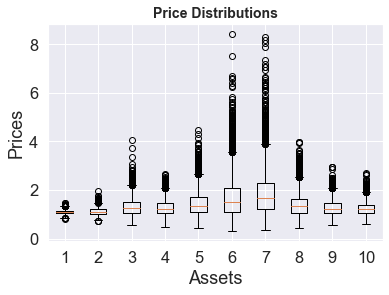

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot(data1)
ax.set_figuresiz
ax.set_title('Price Distributions', fontsize=14, fontweight='bold')
ax.set_xlabel('Assets')
ax.set_ylabel('Prices')

In [75]:
# Expected Covariance in 5 years

asset_prices_y5 = np.stack((A1,A2,A3,A4,a5,a6,a7,a8,a9,a10), axis=1)
asset_names = ['1','2','3','4','5','6','7','8','9','10']
asset_prices_y5_named = pd.DataFrame(asset_prices_y5, columns=asset_names)
asset_prices_y5_named

,1,2,3,4,5,6,7,8,9,10
0,1.061227,1.033672,1.464020,0.929240,1.705953,1.248362,2.473957,1.230989,0.871635,1.316289
1,1.027443,1.050330,1.930240,1.375750,2.444848,3.197330,3.479309,2.245035,1.244231,1.773890
2,1.019728,0.903221,1.236832,1.226682,1.568756,2.724855,1.840353,1.864033,1.074814,1.164286
3,1.123616,1.249501,1.472099,1.400007,1.587047,1.938956,2.106129,1.355111,1.153097,1.349309
4,1.259549,1.254260,1.471624,1.022251,1.379965,1.847527,1.982366,1.743330,1.391609,1.612310
...,...,...,...,...,...,...,...,...,...,...
4995,1.197666,1.096933,1.293657,1.362577,1.390485,1.198399,1.058596,1.518709,0.922718,1.020736
4996,1.023216,1.025281,1.341431,1.163503,1.911335,1.884094,1.975489,1.149850,0.679165,1.489990
4997,1.176421,1.198478,1.186420,0.945732,1.099155,0.856272,1.265671,1.221648,0.892557,1.011747
4998,0.999149,0.970990,1.050308,0.953813,0.779222,0.920088,1.025136,1.326554,1.559714,0.886690


In [76]:
asset_prices_y5_cov_mat = np.cov(asset_prices_y5_named.values.T)
asset_prices_y5_cov_mat

array([[ 0.0083056 ,  0.0073873 ,  0.00352156,  0.0083995 , -0.00376653,
        -0.00771391, -0.01508905, -0.00468105, -0.00312513, -0.00222128],
       [ 0.0073873 ,  0.0190215 ,  0.03018038,  0.02581674,  0.01504082,
         0.02366036,  0.02583922,  0.00601882,  0.00480571,  0.01129624],
       [ 0.00352156,  0.03018038,  0.13212866,  0.07882512,  0.1274145 ,
         0.18384522,  0.19434326,  0.06545981,  0.03389789,  0.0667652 ],
       [ 0.0083995 ,  0.02581674,  0.07882512,  0.09508523,  0.07618135,
         0.14957014,  0.10411557,  0.0262611 ,  0.01812143,  0.03976532],
       [-0.00376653,  0.01504082,  0.1274145 ,  0.07618135,  0.25205762,
         0.28876664,  0.35878552,  0.09049381,  0.06168801,  0.10436019],
       [-0.00771391,  0.02366036,  0.18384522,  0.14957014,  0.28876664,
         0.72107999,  0.52612385,  0.14760987,  0.10327918,  0.14950095],
       [-0.01508905,  0.02583922,  0.19434326,  0.10411557,  0.35878552,
         0.52612385,  0.84606566,  0.16471759

Asset 5 and 6 are equities and asset 7 private equity so that could make sense

In [77]:
"""
Buy and hold strategy 
"""

port_w = np.ones(len(mu)) / len(mu)

buy_and_hold_index = asset_prices @ port_w

In [78]:
buy_and_hold_index

array([[1.        , 1.26758873, 1.24123278, 1.21134757, 1.20048019,
        1.33353439],
       [1.        , 1.14810706, 1.16027005, 1.26324004, 1.60090739,
        1.97684052],
       [1.        , 1.24824598, 1.39412209, 1.40979887, 1.53951193,
        1.46235606],
       ...,
       [1.        , 0.98324697, 1.03995636, 1.08666078, 0.99907173,
        1.08541014],
       [1.        , 0.97869061, 0.977055  , 1.08653778, 1.02369153,
        1.0471665 ],
       [1.        , 1.13155475, 1.32932162, 1.26134702, 1.16523117,
        1.36450153]])

In [73]:
buy_and_hold_index.shape

(5000, 6)

In [82]:
# Presentation of portfolio return data
col_names = ['Year 0','Year 1','Year 2','Year 3','Year 4','Year 5']
buy_and_hold_index_table = pd.DataFrame(buy_and_hold_index, columns=col_names)
buy_and_hold_index_table

,Year 0,Year 1,Year 2,Year 3,Year 4,Year 5
0,1.0,1.267589,1.241233,1.211348,1.200480,1.333534
1,1.0,1.148107,1.160270,1.263240,1.600907,1.976841
2,1.0,1.248246,1.394122,1.409799,1.539512,1.462356
3,1.0,1.053674,1.230074,1.317095,1.417388,1.473487
4,1.0,1.075166,1.221948,1.409492,1.317668,1.496479
...,...,...,...,...,...,...
4995,1.0,1.058244,1.032291,1.038140,1.068884,1.206048
4996,1.0,1.185874,1.297608,1.326396,1.198449,1.364335
4997,1.0,0.983247,1.039956,1.086661,0.999072,1.085410
4998,1.0,0.978691,0.977055,1.086538,1.023692,1.047166


In [95]:
# Define portfolio return

buy_and_hold_index_table
prices_5y = buy_and_hold_index_table['Year 5']
cov_mat_5y = np.cov(prices_5y, rowvar=False)

# Define Relevant Constraints

sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x}

target_returns = np.arange(1.268294, 1.544342, 0.005) # this will depend on the returns of the simulated data. 
# target_returns = np.arange(1.3, 1.526, 0.025)

# Define Optimal Weights

optimal_weights = list()
for target_return in target_returns:
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: np.average(prices_5y @ x) - target_return}


    x0 = np.ones(10) / 10.0
    res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat_5y,),
                                 method='SLSQP',
                                 constraints=[sum_to_one_cons, no_short_cons, target_cons], 
                                 options={'ftol': 1e-9, 'disp': True}, bounds=bounds)
    
    optimal_weights.append(res.x)
    
optimal_weights = np.array(optimal_weights)

NameError: name 'portfolio_variance' is not defined

NameError: name 'fan_chart' is not defined

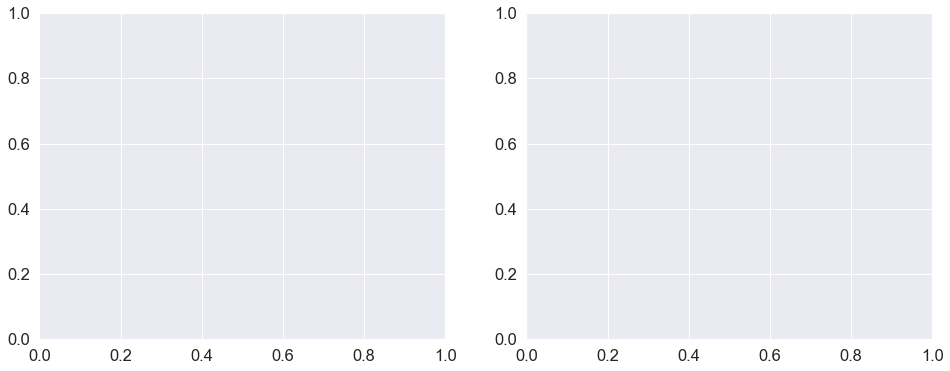

In [18]:
# calculate percentiles
percentiles_buy_and_hold = np.percentile(buy_and_hold_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fan_chart(time_points,
          percentiles_buy_and_hold,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[0])

ax[0].set_xlabel("Year", size=15)
ax[0].set_ylabel("Index value", size=15)
ax[0].set_title("Buy and Hold", size=15)
ax[0].set_ylim([0.5, 3.0])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

In [ ]:
np.mean(buy_and_hold_index[:, 5])

In [19]:
np.median(buy_and_hold_index[:, 5])

1.3420552096123481

Transactions Costs with Asset 5

In [67]:
# Starting Wealth
a0 = 500000

In [89]:
# Defining array of prices of all simulations each year for asset 5
a5_y0 = asset_prices[:,0:1,4:5]
a5_y1 = asset_prices[:,1:2,4:5]
a5_y2 = asset_prices[:,2:3,4:5]
a5_y3 = asset_prices[:,3:4,4:5]
a5_y4 = asset_prices[:,4:5,4:5]
a5_y5 = asset_prices[:,5:6,4:5]

a5_y0_mean = np.mean(a5_y0)
a5_y1_mean = np.mean(a5_y1)
a5_y2_mean = np.mean(a5_y2)
a5_y3_mean = np.mean(a5_y3)
a5_y4_mean = np.mean(a5_y4)
a5_y5_mean = np.mean(a5_y5)

# Transactions Cost
k = 0.02

In [69]:
# Defining the 
a5_y0_cost = (a5_y0_mean*a0-a0)*k
a5_y1_cost = (a5_y1_mean*a0-a0)*k
a5_y2_cost = (a5_y2_mean*a0-a0)*k
a5_y3_cost = (a5_y3_mean*a0-a0)*k
a5_y4_cost = (a5_y4_mean*a0-a0)*k
a5_y5_cost = (a5_y5_mean*a0-a0)*k

In [70]:
x = [0,1,2,3,4,5]
y = [a5_y0_cost,a5_y1_cost,a5_y2_cost,a5_y3_cost,a5_y4_cost,a5_y5_cost]

Text(0.5, 1.0, 'Transactions Costs as a Function of Returns')

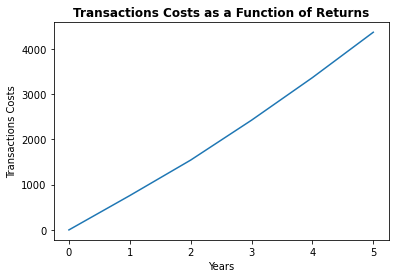

In [71]:
plt.plot(x,y)
plt.xlabel('Years')
plt.ylabel('Transactions Costs')
plt.title('Transactions Costs as a Function of Returns', fontweight='bold')

Utility Function Part

In [87]:


x1 = [a5_y0_mean,a5_y1_mean*a0-a0,a5_y2_mean*a0-a0,a5_y3_mean*a0-a0,a5_y4_mean*a0-a0,a5_y5_mean*a0-a0]
y1 = [a5_y0_cost,a5_y1_cost,a5_y2_cost,a5_y3_cost,a5_y4_cost,a5_y5_cost]

plt.plot(x1,y1)
plt.xlabel('Years')
plt.ylabel('Transactions Costs')
plt.title('Transactions Costs as a Function of Returns', fontweight='bold')

NameError: name 'a5_y0_mean' is not defined